# Gaussian HMM

In [332]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [396]:
eps = 1e-6
class HMM:
    def __init__(self,num_states):
        self.num_states = num_states
        self.initial_probabilities = np.random.rand(self.num_states)
        self.initial_probabilities /= np.sum(self.initial_probabilities)
        self.transition_matrix = np.random.rand(self.num_states,self.num_states)
        for i in range(self.num_states):
            self.transition_matrix[i] /= np.sum(self.transition_matrix[i])
        self.mean = np.zeros(num_states)
        self.variance = np.ones(self.num_states)
    
    def fit(self,observations,iter = 10):
        self.observations = observations
        self.num_observations = len(observations)

        for i in range(iter):
            print("Iteration number: ", i+1)
            if(i==0):
                for i in range(self.num_states):
                    self.mean[i] = np.mean(self.observations)
                    self.variance[i] = np.var(self.observations)
            self.gaussian_emission_matrix()
            self.forward_backward()
            self.false_viterbi()
            self.baum_welch()
        print("Transition matrix ",self.transition_matrix)
        print("Emission matrix ",self.emission_matrix)

    def gaussian_emission_matrix(self):
        # emission_matrix[i,t]
        self.emission_matrix = np.random.random((self.num_states,self.num_observations))

        for i in range(0,self.num_states):
            self.emission_matrix[i] = np.exp(-(((self.observations - self.mean[i]) **2/ (self.variance[i] if self.variance[i]!=0 else eps)) / (2)))
            self.emission_matrix[i] /= np.sqrt(2 * np.pi * (self.variance[i] if self.variance[i]!=0 else eps))
            self.emission_matrix[i] /= np.sum(self.emission_matrix[i])

    def forward_backward(self):
        # alpha[t, i]
        alpha = np.random.random((self.num_observations, self.num_states))
        alpha[0,:] = self.initial_probabilities * self.emission_matrix[:,0]
        
        for t in range(1,self.num_observations):
            for i in range(0,self.num_states):
                alpha[t,i] = np.sum(np.fromiter(
                    (alpha[t-1,j] * self.transition_matrix[j,i] * self.emission_matrix[i,t] for j in range(self.num_states)),
                    dtype = float
                ))
        self.alpha = alpha
        # beta[t, i]
        beta = np.random.random((self.num_observations, self.num_states))
        beta[-1,:] = np.ones(self.num_states)
        
        for t in range(self.num_observations-1):
            for i in range(0,self.num_states):
                beta[t,i] = np.sum(np.fromiter(
                    (beta[t+1,j] * self.transition_matrix[i,j] * self.emission_matrix[i,t+1] for j in range(self.num_states)),
                    dtype = float
                ))
        self.beta = beta

    def false_viterbi(self):
        # not really viterbi, gamma[t,i]
        gamma = self.alpha * self.beta
        gamma /= np.sum(gamma, axis=1, keepdims=True)
        self.gamma = gamma
    
    def update_initial_probabilities(self):
        self.initial_probabilities = self.gamma[0]

    def update_transition_matrix(self):
        for i in range(self.num_states):
            for j in range(self.num_states):
                anew = 0
                for t in range(self.num_observations-1):
                    anew += self.zeta[t,i,j]
                sum = 0
                for t in range(self.num_observations-1):
                    sum += np.sum(self.zeta[t, i, :])
                anew = anew/sum
                self.transition_matrix[i][j] = anew
        
    def update_emission_parameters(self):
        for i in range(self.num_states):
            self.mean[i] = np.sum((self.gamma[t, i] * self.observations[t]) for t in range(self.num_observations)) 
            self.mean[i] /= np.sum(self.gamma[:, i]) if np.sum(self.gamma[:, i]) != 0 else eps
            self.variance[i] = np.sum((self.gamma[t, i] * ((self.observations[t] - self.mean[i]) ** 2)) for t in range(self.num_observations))
            self.variance[i] /= np.sum(self.gamma[:, i]) if np.sum(self.gamma[:, i]) != 0 else eps 
        
    def baum_welch(self):
        # zeta[t-1, i, j]
        zeta = np.random.random((self.num_observations-1,self.num_states,self.num_states))
        for t in range(self.num_observations-1):
            for i in range(self.num_states):
                for j in range(self.num_states):
                    zeta[t,i,j] = self.alpha[t,i] * self.transition_matrix[i,j] * self.emission_matrix[j,t+1] * self.beta[t+1,j]          
            zeta[t] /= np.sum(self.alpha[t,i]*self.beta[t,i] for i in range(self.num_states))
        self.zeta = zeta
        
        self.update_initial_probabilities()
        self.update_transition_matrix()
        self.update_emission_parameters()

    def predict(self, test):
        # viterbi
        viterbi =  np.random.random((self.num_states, self.num_observations+len(test)))
        for i in range(self.num_states):
            viterbi[i,0] = self.initial_probabilities[i] * self.emission_matrix[i,0]
        for t in range(1,self.num_observations):
            for s in range(self.num_states):
                viterbi[s,t] = max(viterbi[s1,t-1]*self.transition_matrix[s1,s] for s1 in range(self.num_states))*self.emission_matrix[s,t]
        predictions = []

        emission_sum=[0]*self.num_states
        for s in range(self.num_states):
            cur = np.exp(-(((self.observations - self.mean[s]) **2/ (self.variance[s] if self.variance[s]!=0 else eps)) / (2)))
            cur /= np.sqrt(2 * np.pi * (self.variance[s] if self.variance[s]!=0 else eps))
            emission_sum[i] = np.sum(cur)

        for i in range(len(test)):
            val = 0
            sum = 0
            t = self.num_observations + i
            for s in range(self.num_states):
                val = val + viterbi[s,t-1]*self.mean[s]
                sum = sum + viterbi[s,t-1]

            for s in range(self.num_states):
                viterbi[s,t-1] = viterbi[s,t-1]/sum
                self.mean[s] = self.mean[s] + (test[i] - self.mean[s])*viterbi[s,t-1]
                self.variance[s] = self.variance[s] + ((test[i] - self.mean[s])**2)*viterbi[s,t-1]
            
            predictions.append(val/sum)

            for j in range(self.num_states):
                emission = np.exp(-(((test[i] - self.mean[j]) **2/ (self.variance[j] if self.variance[j]!=0 else eps)) / (2)))
                emission /= np.sqrt(2 * np.pi * (self.variance[j] if self.variance[j]!=0 else eps))
                emission_sum[j] += emission
                emission = emission/emission_sum[j]
                viterbi[j,t] = max(viterbi[s,t-1]*self.transition_matrix[s,j] for s in range(self.num_states))*emission
        return predictions
                

In [397]:
df = pd.read_csv('btcusdt_1h.csv')
df

,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13529.01,443.356199
1,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006
2,2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572
3,2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030
4,2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329
...,...,...,...,...,...,...
35203,2022-01-12 01:30:00,42972.04,43095.26,42692.19,42800.38,1219.601780
35204,2022-01-12 02:30:00,42797.62,42823.69,42643.74,42659.20,702.103800
35205,2022-01-12 03:30:00,42664.71,42776.14,42597.41,42713.13,561.859930
35206,2022-01-12 04:30:00,42713.12,42886.28,42633.97,42729.29,681.142010


In [400]:
train = np.array(df['close'][:80])
test = np.array(df['close'][80:160])

model = HMM(5)
model.fit(train)
ans = model.predict(test)
print("Predictions: ", ans)

Iteration number:  1
Iteration number:  2
Iteration number:  3
Iteration number:  4
Iteration number:  5
Iteration number:  6
Iteration number:  7
Iteration number:  8
Iteration number:  9
Iteration number:  10
Transition matrix  [[1.14697662e-01 7.21817808e-06 6.23501886e-14 9.10561554e-02
  7.94238964e-01]
 [1.54122945e-01 2.44597788e-04 7.18469676e-03 3.62950845e-03
  8.34818252e-01]
 [3.57954640e-02 1.11881592e-01 1.81842230e-01 7.03167457e-02
  6.00163969e-01]
 [1.51373600e-01 3.78140035e-05 4.27955084e-05 2.08338454e-05
  8.48524956e-01]
 [1.09314154e-01 3.45042823e-06 1.43977432e-13 8.07030273e-02
  8.09979368e-01]]
Emission matrix  [[2.78929567e-16 5.28003247e-24 8.58119194e-21 6.61220782e-19
  8.42984359e-15 1.17978890e-15 1.81629247e-11 2.02035419e-15
  6.69512974e-17 1.75105470e-14 1.98822152e-15 1.51276576e-23
  8.14037974e-25 3.66578743e-29 8.72638427e-24 7.26591179e-23
  3.92056931e-29 5.12765849e-29 7.92360932e-26 4.91393171e-23
  3.72609174e-19 2.58975750e-17 5.91305099

C:\Users\Aditya\AppData\Local\Temp\ipykernel_11516\3058968362.py:98: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  zeta[t] /= np.sum(self.alpha[t,i]*self.beta[t,i] for i in range(self.num_states))
C:\Users\Aditya\AppData\Local\Temp\ipykernel_11516\3058968362.py:86: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.mean[i] = np.sum((self.gamma[t, i] * self.observations[t]) for t in range(self.num_observations))
C:\Users\Aditya\AppData\Local\Temp\ipykernel_11516\3058968362.py:88: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.variance[i] = np.sum((self.gamma[t, i] * ((self.observations

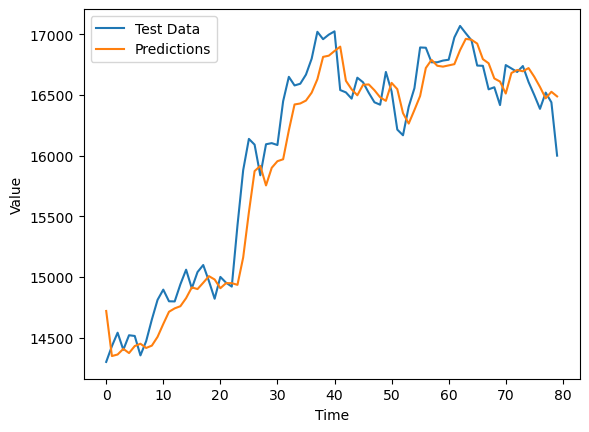

In [401]:
plt.plot(test, label='Test Data')
plt.plot(ans, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

In [402]:
df_ = pd.read_csv('btcusdt_3m.csv')
df

,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13529.01,443.356199
1,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006
2,2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572
3,2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030
4,2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329
...,...,...,...,...,...,...
35203,2022-01-12 01:30:00,42972.04,43095.26,42692.19,42800.38,1219.601780
35204,2022-01-12 02:30:00,42797.62,42823.69,42643.74,42659.20,702.103800
35205,2022-01-12 03:30:00,42664.71,42776.14,42597.41,42713.13,561.859930
35206,2022-01-12 04:30:00,42713.12,42886.28,42633.97,42729.29,681.142010


In [403]:
train_ = np.array(df_['close'][:100])
test_ = np.array(df_['close'][100:200])

model_ = HMM(10)
model_.fit(train_)
ans_ = model_.predict(test_)
print("Predictions: ", ans_)

Iteration number:  1
Iteration number:  2


C:\Users\Aditya\AppData\Local\Temp\ipykernel_11516\3058968362.py:98: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  zeta[t] /= np.sum(self.alpha[t,i]*self.beta[t,i] for i in range(self.num_states))
C:\Users\Aditya\AppData\Local\Temp\ipykernel_11516\3058968362.py:86: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.mean[i] = np.sum((self.gamma[t, i] * self.observations[t]) for t in range(self.num_observations))
C:\Users\Aditya\AppData\Local\Temp\ipykernel_11516\3058968362.py:88: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.variance[i] = np.sum((self.gamma[t, i] * ((self.observations

Iteration number:  3
Iteration number:  4
Iteration number:  5
Iteration number:  6
Iteration number:  7
Iteration number:  8
Iteration number:  9
Iteration number:  10
Transition matrix  [[8.68648236e-01 5.03413020e-02 1.18642900e-02 1.85258992e-09
  1.01659389e-06 4.72586359e-03 4.00478691e-02 1.87551726e-02
  2.39170139e-03 3.22454668e-03]
 [8.26854857e-01 9.49073516e-02 1.24217310e-02 2.16345048e-09
  9.79789162e-07 3.49480028e-02 2.68736921e-03 2.42870348e-02
  3.05171650e-04 3.58749970e-03]
 [3.77896083e-01 2.07450799e-01 9.68224941e-02 4.10255956e-05
  9.34840442e-04 1.34403882e-01 9.67429907e-02 2.10035768e-02
  3.25953926e-02 3.21089158e-02]
 [1.47773819e-05 5.00752320e-06 3.08216454e-06 7.02779788e-01
  2.83617429e-01 2.33921649e-04 1.84236354e-04 3.77942477e-04
  7.04099418e-03 5.74282127e-03]
 [1.20143183e-03 1.35001625e-04 5.03720808e-04 9.53266108e-01
  2.08611204e-02 8.25938268e-05 1.50290971e-03 4.10060238e-03
  6.06675074e-03 1.22797605e-02]
 [2.51980445e-01 9.87031461

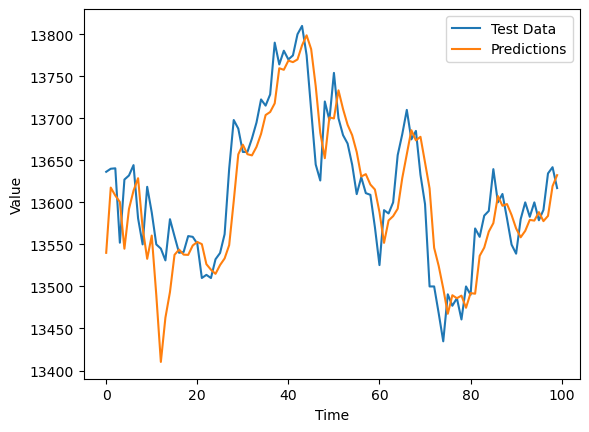

In [404]:
plt.plot(test_, label='Test Data')
plt.plot(ans_, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()